In [89]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '3d761435-fe4f-4829-a33e-26fc52a46613'
SCHEME_ID = '4658a522-0626-4074-b207-ed46ea13d2a1'

JOSEFINE = '45c63ef0-2af7-4652-b096-cff368497fea'
FELIX = '6f57074c-b145-4826-a20c-2aba8939758f'
LYNN = '8049cefa-6f2a-4fed-8b71-ca9424dd99c6'
NIKOLA = '3cd7dc2a-f920-4699-898e-7760ef7fb063'

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID).order_by(Import.name)).scalars().all()
    for r in rslt:
        print(f"'{r.import_id}': '{r.name}',")

In [54]:
IMPORTS_ORIG = {
    'dce23cb8-901a-42ef-995d-e2b2dc7ddce3': 'Original data (bikes and scooters)',
    'b5ea5cff-7856-433f-a6ec-2c5510a23293': 'Original data (buildings)',
    '18a17c5f-c96d-4fa4-b0a1-a639193ea1f7': 'Original data (transport)',
    'beb43723-d07a-4224-999e-d4e50f5b0744': 'Original data (urban form)',
    '13ef9fb4-8d10-4a1e-b35d-3c8b7d6f4ad3': 'Original data (waste)',
}

#IMPORTS_NEW = {
#    '8ea4d66e-3918-48f4-9bc6-574feb885dcd': 'Updated WoS (01.07.2024) | Bikes',
#    '3b36cac1-89f5-45da-bb63-63d575cc7ac5': 'Updated WoS (01.07.2024) | Buildings',
#    'a8de6a28-1e92-4468-8fa9-30dd9fa4df83': 'Updated WoS (01.07.2024) | Transport',
#    '1e799d77-c6f1-4f25-916f-07f6a1189351': 'Updated WoS (01.07.2024) | Urban form',
#    '419bd950-7847-4df3-959f-8c98e6bfb863': 'Updated WoS (01.07.2024) | Waste',
#}

IMPORTS_UPD_PRE = {
    '22c15f11-eaa2-486a-9812-e6520fe75e22': 'Updated Query (11.07.2024) | < 2022 | Bikes',
    '83aa7428-945f-4e4a-b368-350e549d5e40': 'Updated Query (11.07.2024) | < 2022 | Buildings',
    'ceb6a7b1-353b-451e-a56b-bda86a543bd0': 'Updated Query (11.07.2024) | < 2022 | Transport',
    'ef69e746-2f64-4cb2-86d0-c3b4154531e9': 'Updated Query (11.07.2024) | < 2022 | Urban form',
    '06547d84-8f9a-4b22-993d-e1cbf7e6b54e': 'Updated Query (11.07.2024) | < 2022 | Waste',
}
IMPORTS_UPD_POST = {
    '9b656ac6-bc73-43fa-ab75-2970c4c138f2': 'Updated Query (11.07.2024) | >= 2022 | Waste',
    '8998c855-3d5b-45de-a53b-b6e1c94859b5': 'Updated Query (11.07.2024) | >= 2022 | Urban form',
    '28f2f944-83b3-4cca-8d32-9066736ae8b0': 'Updated Query (11.07.2024) | >= 2022 | Transport',
    '347c4fd1-70ba-49b1-b174-2251bd672070': 'Updated Query (11.07.2024) | >= 2022 | Buildings',
    '10046573-819c-4fb5-8aa1-3d92ab682701': 'Updated Query (11.07.2024) | >= 2022 | Bikes',
}

IMPORTS_UPD = IMPORTS_UPD_PRE | IMPORTS_UPD_POST
IMPORTS = IMPORTS_ORIG | IMPORTS_UPD_PRE | IMPORTS_UPD_POST

# Data preparation

In [3]:
stmt = text('''
WITH labels_flat as (SELECT i.item_id, json_build_object(ba.key, ba.value_int) as label
                     FROM item i
                              JOIN bot_annotation ba ON ba.item_id = i.item_id
                     WHERE i.project_id = '3d761435-fe4f-4829-a33e-26fc52a46613'
                       AND ba.key = ANY (array [
                         'incl','cluster',
                         'imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta'
                         ])
                       AND ba.bot_annotation_metadata_id::text = ANY (array [
                         'b386ae78-ae35-428a-be34-abceab9dba3f', -- Resolution for "Waste"
                         '0057dc42-5821-445b-b3d5-834d0958d110', -- Resolution for "urban form"
                         'c42b71c7-f1dc-46b2-b187-72fa78f8a397', -- Resolution for "buildings"
                         'c77b8462-7ab5-4bac-b686-6008c8fbe727', -- Resolution for "transport"
                         'be1361b6-35ed-4509-bc2a-da10c9d83e91' -- Resolution for "bikes and scooters"
                         ])),
     labels as (SELECT item_id, json_agg(label) as labels
                FROM labels_flat
                GROUP BY item_id),
     imports as (SELECT item_id, array_agg(DISTINCT import_id) as imports
                 FROM m2m_import_item mii
                 GROUP BY item_id)
SELECT i.item_id,
       i.text              as abstract,
       ai.title,
       ai.publication_year as py,
       ai.wos_id,
       ai.doi,
       labels.labels,
       imports.imports
FROM item i
         JOIN academic_item ai on i.item_id = ai.item_id
         LEFT OUTER JOIN labels ON i.item_id = labels.item_id
         LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = '3d761435-fe4f-4829-a33e-26fc52a46613';
''')

with db_engine.session() as session:
    rslt = session.execute(stmt).mappings().all()

In [4]:
IMPACT_KEYS = ['imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta']
IMPACTS = [{'name': 'Appliance efficiency', 'hint': 'Appliances that can perform a given task needed less energy.', 'value': 0}, {'name': 'Building-level energy consumption', 'hint': 'Focus on overall emissions of building and the reduction thereof, focus on mapping/understanding where high consumption settings are as opposed to actively trying to reduce known high consumption settings.', 'value': 1}, {'name': 'Building retrofit envelope', 'hint': 'Retrofit approach with added insulation and an air barrier around existing walls to improve thermal comfort and reduce drafts.', 'value': 2}, {'name': 'Consumer behavior', 'hint': 'Emission reduction due to changed consumption behavior of residents, linked to appliance efficiency and fuel switch.', 'value': 3}, {'name': 'Demand response', 'hint': 'Change in electricity consumption by end-user(s) (technologies) to help balance the electricity grid or benefit from periods of high availability of renewable energy.', 'value': 4}, {'name': 'District heating and cooling', 'hint': 'Grouped supply for heating and/or cooling for several (typically residential or commercial) buildings, leading to a more energy-efficient supply.', 'value': 5}, {'name': 'Fuel switch', 'hint': 'Changing the type of energy, electricity, and gas, fueling the building  operations e.g. from fossil fuel to renewables.', 'value': 6}, {'name': 'New efficient buildings', 'hint': 'Energy efficient construction and operation as a requirement of newly built stock e.g. via standards.', 'value': 7}, {'name': 'Operational efficiency', 'hint': 'Use of technology that can perform a given task needs less energy e.g. HVAC or lighting.', 'value': 8}, {'name': 'Alternative fuels and infrastructure', 'hint': 'Switching to bio-based fuels and establishing respective distribution and charging infrastructure.', 'value': 9}, {'name': 'Autonomous vehicles', 'hint': 'A vehicle capable of sensing its environment and operating without human involvement.', 'value': 10}, {'name': 'Battery-electrified transport', 'hint': 'Enabling or supporting the use of electric vehicles, public and non-public transport.', 'value': 11}, {'name': 'Charging infrastructure', 'hint': 'Putting in place charging points, linked to convenient parking, matching the demand.', 'value': 12}, {'name': 'Consumer behavior', 'hint': 'Impact based on the choices made by users over mode of transport, distance, and number of trips.', 'value': 13}, {'name': 'Freight operations and routing', 'hint': 'Trips for logistics and delivery of goods, can include policies around speed, parking, and allowed hours.', 'value': 14}, {'name': 'Micromobility', 'hint': 'Range of small, lightweight vehicles operating at low speeds.', 'value': 15}, {'name': 'Pedestrian-cyclist interaction', 'hint': "Includes dynamics between pedestrian flow and cyclists' routes.", 'value': 16}, {'name': 'Not pooled shared mobility', 'hint': 'Vehicle sharing over time, personal rental, no private ownership, shared costs.', 'value': 17}, {'name': 'Pooled shared mobility', 'hint': 'Simultaneous ride-sharing, cost sharing.', 'value': 18}, {'name': 'Public transport O & M', 'hint': 'Changes to operation and maintenance within the existing network.', 'value': 19}, {'name': 'Public transport planning', 'hint': 'Includes conceptualization, ideation, analysis, and design of interventions on existing routes, creation of new routes, and mobility options. Buses, metro, train, trams.', 'value': 20}, {'name': 'Roadway electrification', 'hint': 'Building roads that supply electric power to vehicles e.g. trucks travelling on it.', 'value': 21}, {'name': 'Shared bikes and scooters', 'hint': 'Network of bikes and scooters that can be rented for a period of time by users who pay only for the duration of use.', 'value': 22}, {'name': 'Traffic management and routing', 'hint': 'Optimisation of traffic flow, identification of patterns to improve routing, can include traffic light rhythm.', 'value': 23}, {'name': 'Utility vehicle fleets', 'hint': 'Vehicles for specific tasks such as waste trucks, street cleaning vehicles, maintenance operations, and snow trucks.', 'value': 24}, {'name': 'Vehicle efficiency', 'hint': 'Improvements in driving cycles and fuel consumption.', 'value': 25}, {'name': 'Spatial configuration and transport energy consumption', 'hint': 'Dependencies between spatial configurations and transport energy consumption.', 'value': 26}, {'name': 'Urban & neighborhood design', 'hint': 'Includes place-making, master planning, and interventions based on the design process.', 'value': 27}, {'name': 'Utility infrastructure planning', 'hint': 'System-level conceptualization/ configuration of water and energy grids and other resource flows.', 'value': 28}, {'name': 'Zoning, land use, green space', 'hint': 'Specifications around the type of activities allowed or intended e.g. industrial, residential, mixed-use. often based on local plans or planning policies. zoning is common in the USA.', 'value': 29}, {'name': 'Street network design', 'hint': 'Process to determine hierarchies between streets, linkages, and crossings. Both at the neighborhood and city levels.', 'value': 30}, {'name': 'CO2 emission & energy consumption prediction', 'hint': 'Mapping CO2 emissions in cities across sectors and linking their values to urban form characteristics.', 'value': 31}, {'name': 'Multi-city comparison', 'hint': 'Comparative studies involving different urban contexts, in the same or different countries.', 'value': 32}, {'name': 'Street lighting', 'hint': 'Agile management and increased efficiency of public lighting  infrastructure.', 'value': 33}, {'name': 'Circular economy', 'hint': 'Processes to convert waste to resource, to divert waste from landfill, include recycling, and composting with clear climate mitigation relevance.', 'value': 34}, {'name': 'Municipal solid waste management', 'hint': 'Management of processing waste types consisting of everyday items that are discarded by the public, including collection and transport of waste to the place of treatment or discharge by municipal services.', 'value': 35}, {'name': 'Waste to energy', 'hint': 'Waste treatment processes that creates energy in the form of electricity, heat or transport fuels, biomass gasification.', 'value': 36}, {'name': 'Wastewater management', 'hint': 'Generation of the polluted form of water ie. sewage (rainfall and human activities), treatment as the process used to remove contaminants from wastewater and convert it into an effluent that can be returned to the water cycle.', 'value': 37}, {'name': 'Food loss and waste', 'hint': 'A decrease at all stages of the food system from production to consumption, in mass and/or quality, of food that was originally intended for human consumption, regardless of the cause.', 'value': 38}, {'name': 'Landfill methane emission prediction', 'hint': 'Forecasting amount of methane gas as a natural byproduct of the decomposition of organic material in landfills.', 'value': 39}, {'name': 'Modeling method contribution', 'hint': 'Focus on creating or advancing an ML method in accuracy or calculation pace.', 'value': 40}, {'name': 'Dataset provision & Data imputation', 'hint': 'Using ML for data acquisition and substitution.', 'value': 41}, {'name': 'Multi-stakeholder planning process', 'hint': 'Integration of different stakeholder groups like citizens, private or public sector.', 'value': 42}]
CLUSTERS = [{'name': 'Buildings', 'value': 0}, {'name': 'Transport', 'value': 1}, {'name': 'Urban form', 'value': 2}, {'name': 'Waste', 'value': 3}, {'name': 'Meta-characteristics', 'value': 4}]

data = [{
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels': r['labels'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },
        **{
            k if k not in IMPACT_KEYS else 'impact': v
            for li in (r['labels'] or [])
            for k, v in li.items()
        },
        **{
            f'impact|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k in IMPACT_KEYS
        },
        **{
            f'cluster|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k == 'cluster'
        }
    } for r in rslt]

df = pd.DataFrame(data)    
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

df['import_orig'] = oring([df[k].astype(bool) for k in IMPORTS_ORIG.values()])
df['import_upd'] = oring([df[k].astype(bool) for k in IMPORTS_UPD.values()])
df['import_upd_pre'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_PRE.values()])
df['import_upd_post'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_POST.values()])

mask_seen = ~df['labels'].isna()
mask_unseen = df['labels'].isna()

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
print(f'Updated import: {df['import_upd'].sum():,} | '
      f'old import: {df['import_orig'].sum():,} | '
      f'overlap: {(df['import_upd'] & df['import_orig']).sum():,}')
print(f'old and seen: {(df['import_orig'] & mask_seen).sum():,} | '
      f'new and seen: {(df['import_upd'] & mask_seen).sum():,}')
print(f'old and unseen: {(df['import_orig'] & mask_unseen).sum():,} | '
      f'new and unseen: {(df['import_upd'] & mask_unseen).sum():,}')
df.head()

Shape: (6521, 75)
Seen: 2,823 | unseen: 3,698
Updated import: 5,049 | old import: 2,268 | overlap: 1,664
old and seen: 2,226 | new and seen: 1,707
old and unseen: 42 | new and unseen: 3,342


item_id  \
0  00042c95-05f2-4265-94da-0b798e68ef67   
1  002103df-3522-401e-b8cf-37c3f8de08b9   
2  0025bae6-5100-49ec-b4e9-8e7ad5c59233   
3  003ec709-1f1a-4459-9023-49471df2b8a6   
4  005411f3-84cf-4da9-8678-2e92de53c052   

                                               title  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...   
1  Computer Vision classifier and platform for au...   
2  A New Method for Traffic Participant Recogniti...   
3  Many-Objective Optimization Design of a Public...   
4  The Nutrient Status of Plant Roots Reveals Com...   

                                            abstract  \
0  In this paper, we first propose lightweight de...   
1  Data on urban mobility is traditionally obtain...   
2  The latest survey results show an increase in ...   
3  The energy performance of buildings especially...   
4  Controversial competition theories may confuse...   

                                                text               wos_id  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...                 None   
1  Computer Vision classifier and platform for au...                 None   
2  A New Method for Traffic Participant Recogniti...  WOS:001256471000001   
3  Many-Objective Optimization Design of a Public...                 None   
4  The Nutrient Status of Plant Roots Reveals Com...                 None   

                   doi    py                                           labels  \
0                 None  2019                                    [{'incl': 0}]   
1                 None  2017                                    [{'incl': 0}]   
2    10.3390/s24123832  2024                                             None   
3  10.3390/app10072435  2020  [{'cluster': 0}, {'imp_build': 8}, {'incl': 1}]   
4    10.3390/f11111163  2020                                    [{'incl': 0}]   

                                  imports Original data (bikes and scooters)  \
0  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   
1  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   
2  [10046573-819c-4fb5-8aa1-3d92ab682701]                               None   
3  [b5ea5cff-7856-433f-a6ec-2c5510a23293]                               None   
4  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]                               True   

   incl Updated Query (11.07.2024) | >= 2022 | Bikes  \
0     0                                         None   
1     0                                         None   
2  None                                         True   
3     1                                         None   
4     0                                         None   

  Original data (buildings) cluster impact impact|8 cluster|0  \
0                      None    None   None     None      None   
1                      None    None   None     None      None   
2                      None    None   None     None      None   
3                      True       0      8     True      True   
4                      None    None   None     None      None   

  Updated Query (11.07.2024) | < 2022 | Bikes  \
0                                        None   
1                                        None   
2                                        None   
3                                        None   
4                                        None   

  Updated Query (11.07.2024) | < 2022 | Buildings  \
0                                            None   
1                                            None   
2                                            None   
3                                            None   
4                                            None   

  Updated Query (11.07.2024) | < 2022 | Transport  \
0                                            None   
1                                            None   
2                                            None   
3                                            None   
4                                            None   

  Updat

In [5]:
df['incl'].value_counts()

incl
0    1642
1    1181
Name: count, dtype: int64

# Training and prediction

In [6]:
import torch
import evaluate
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM


def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    return {
        'recall': evaluate.load('recall').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['recall'],
        'precision': evaluate.load('precision').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['precision'],
        'f1': evaluate.load('f1').compute(predictions=predictions, references=labels, labels=np.arange(len(labels)), average='weighted')['f1'],
        'accuracy': evaluate.load('accuracy').compute(predictions=predictions, references=labels, normalize=False)['accuracy']
    }

dfi = df[~df['incl'].isna()][['text', 'incl']].copy()
dfi['label'] = dfi['incl']
labels = ['Exclude', 'Include']
lnames = ['Exclude', 'Include']
pcols = ['pred_incl|0', 'pred_incl|1']
pcol = 'pred_incl'

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, model_max_length=512)

BATCH_SIZE_PRED = 50

df_train = dfi.sample(frac=0.8)
mask_train = dfi.index.isin(df_train.index)
mask_test = ~mask_train

df_test = dfi[mask_test]
labels = list(dfi['label'].unique())

print('labels', labels)
print('columns', pcols)
print('mask train', mask_train.sum(), 'test', mask_test.sum())
print('df train', df_train.shape, 'test', df_test.shape)
print()
print('train')
print(df_train['label'].value_counts())
print('test')
print(df_test['label'].value_counts())

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

eval_dataset = Dataset.from_pandas(df_test)
eval_dataset = eval_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

print(len(train_dataset), len(eval_dataset))

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    logging_dir='data/logs',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=50,
    warmup_steps=400,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print('Training model...')
trainer.train()

print('Predicting...')
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format('torch')

    for batch in tqdm(ds.iter(batch_size=BATCH_SIZE_PRED)):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

preds = torch.concatenate(preds)

2024-07-15 13:20:54,733 [INFO] datasets: PyTorch version 2.3.1 available.
2024-07-15 13:20:54,734 [INFO] datasets: TensorFlow version 2.16.1 available.
2024-07-15 13:20:55.613457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 13:20:56.314901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


labels [0, 1]
columns ['pred_incl|0', 'pred_incl|1']
mask train 2258 test 565
df train (2258, 3) test (565, 3)

train
label
0    1317
1     941
Name: count, dtype: int64
test
label
0    325
1    240
Name: count, dtype: int64


Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

2258 565
Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon INFO @ 13:21:00] [setup] RAM Tracking...
[codecarbon INFO @ 13:21:00] [setup] GPU Tracking...
[codecarbon INFO @ 13:21:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:21:00] [setup] CPU Tracking...
[codecarbon WARNING @ 13:21:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:21:01] We saw that you have a AMD Ryzen 7 5700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 13:21:01] CPU Model on constant consumption mode: AMD Ryzen 7 5700X 8-Core Processor
[codecarbon INFO @ 13:21:01] >>> Tracker's metadata:
[codecarb

Training model...


[codecarbon INFO @ 13:21:19] Energy consumed for RAM : 0.000098 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 13:21:19] Energy consumed for all GPUs : 0.000621 kWh. Total GPU Power : 148.90602019711005 W
[codecarbon INFO @ 13:21:19] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:21:19] 0.000896 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:34] Energy consumed for RAM : 0.000196 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 13:21:34] Energy consumed for all GPUs : 0.001195 kWh. Total GPU Power : 137.93947680726774 W
[codecarbon INFO @ 13:21:34] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:21:34] 0.001746 kWh of electricity used since the beginning.
/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted sample

Predicting...


Map:   0%|          | 0/6521 [00:00<?, ? examples/s]

131it [01:09,  1.90it/s]


In [7]:
df[pcol] = preds.argmax(dim=1)
for li, c in enumerate(pcols):
    df[c] = preds[:,li]

df.loc[df_train.index, 'train'] = 1
df.loc[df_test.index, 'test'] = 1

df.to_feather(f'data/screening_round_01.arrow')

# Evaluation

In [8]:
labels

[0, 1]

In [9]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_pred = df[df['test']==1][pcols].to_numpy()
    
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=lnames))

              precision    recall  f1-score   support

     Exclude       0.83      0.84      0.83       325
     Include       0.78      0.76      0.77       240

    accuracy                           0.81       565
   macro avg       0.80      0.80      0.80       565
weighted avg       0.80      0.81      0.81       565



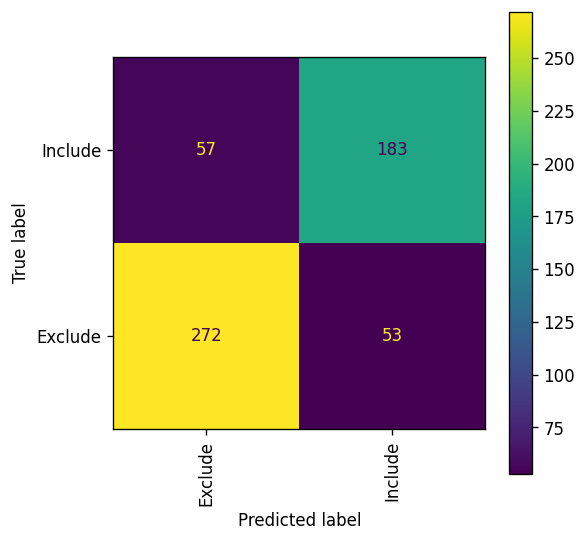

In [10]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
#ax.set_title(col)
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred.argmax(axis=1),
    labels=list(range(len(lnames))),
    display_labels=lnames,
    xticks_rotation='vertical',
    ax=ax
)
ax.invert_yaxis()
fig.show()

/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


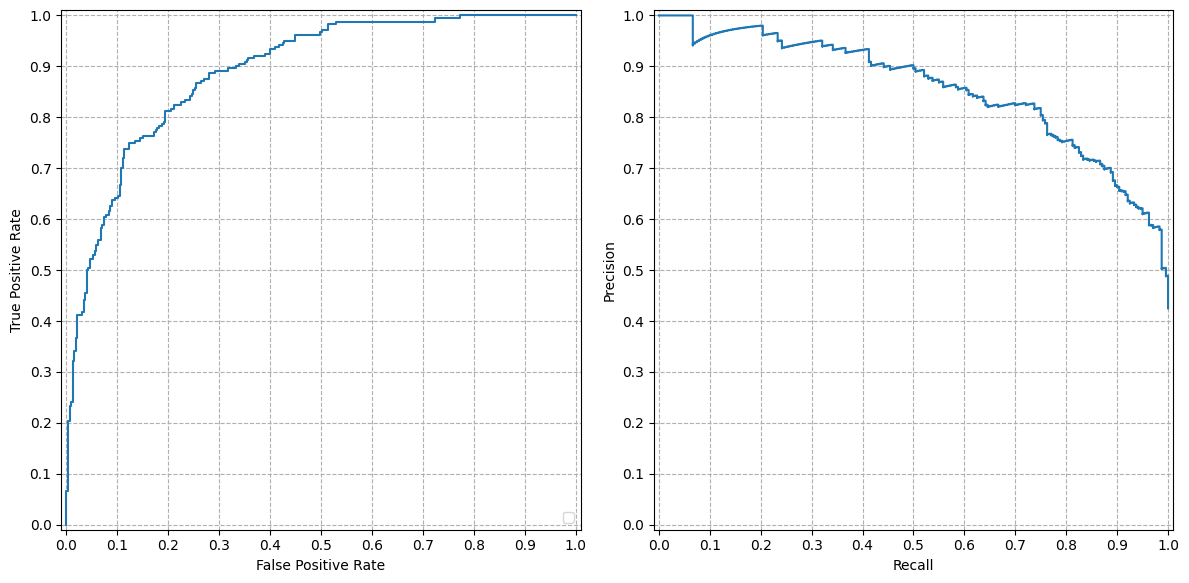

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_scores = df[df['test']==1]['pred_incl|1'].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(visible=True, linestyle='--')
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(visible=True, linestyle='--')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of classifier scores in test set')

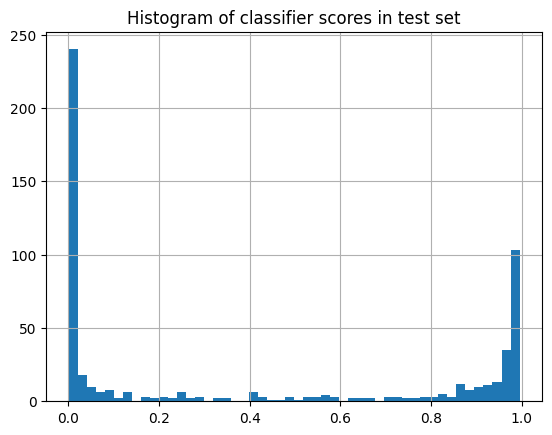

In [12]:
ax = df[df['test']==1]['pred_incl|1'].hist(bins=50)
ax.set_title('Histogram of classifier scores in test set')

# Analysis

In [13]:
pd.DataFrame([precision, recall, thresholds])

0         1         2         3         4         5         6    \
0  0.424779  0.425532  0.426288  0.427046  0.427807  0.428571  0.429338   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000502  0.000659  0.000747  0.000788  0.000824  0.000833  0.000837   

        7         8         9         10        11        12        13   \
0  0.430108  0.430880  0.431655  0.432432  0.433213  0.433996  0.434783   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000866  0.000876  0.000883  0.000905  0.000908  0.000912  0.000913   

        14        15        16        17        18       19        20   \
0  0.435572  0.436364  0.437158  0.437956  0.438757  0.43956  0.440367   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.00000  1.000000   
2  0.000915  0.000971  0.000992  0.001002  0.001036  0.00105  0.001054   

        21        22        23        24        25        26        27   \
0  0.441176  0.441989  0.442804  0.443623  0.444444  0.445269  0.446097   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001071  0.001074  0.001080  0.001088  0.001098  0.001099  0.001105   

        28        29        30        31        32        33        34   \
0  0.446927  0.447761  0.448598  0.449438  0.450281  0.451128  0.451977   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001106  0.001111  0.001112  0.001114  0.001125  0.001127  0.001141   

        35        36        37        38        39        40        41   \
0  0.452830  0.453686  0.454545  0.455408  0.456274  0.457143  0.458015   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001164  0.001179  0.001181  0.001191  0.001197  0.001237  0.001243   

        42       43        44        45        46        47        48   \
0  0.458891  0.45977  0.460653  0.461538  0.462428  0.463320  0.464217   
1  1.000000  1.00000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001243  0.00125  0.001258  0.001273  0.001273  0.001275  0.001278   

        49        50        51        52        53        54        55   \
0  0.465116  0.466019  0.466926  0.467836  0.468750  0.469667  0.470588   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001285  0.001305  0.001317  0.001317  0.001329  0.001334  0.001340   

        56        57        58        59        60        61        62   \
0  0.471513  0.472441  0.473373  0.474308  0.475248  0.476190  0.477137   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001341  0.001363  0.001383  0.001383  0.001399  0.001421  0.001424   

        63        64        65        66        67        68        69   \
0  0.478088  0.479042  0.480000  0.480962  0.481928  0.482897  0.483871   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.001436  0.001446  0.001456  0.001468  0.001481  0.001496  0.001507   

        70       71        72        73        74        75        76   \
0  0.484848  0.48583  0.486815  0.487805  0.488798  0.487755  0.488753   
1  1.000000  1.00000  1.000000  1.000000  1.000000  0.995833  0.995833   
2  0.001532  0.00155  0.001550  0.001559  0.001596  0.001597  0.001634   

        77        78        79        80        81        82        83   \
0  0.489754  0.490760  0.491770  0.492784  0.493802  0.494824  0.495851   
1  0.995833  0.995833  0.995833  0.995833  0.995833  0.995833  0.995833   
2  0.001638  0.001640  0.001644  0.001651  0.001669  0.001677  0.001698   

        84        85        86        87        88        89        90   \
0  0.496881  0.497917  0.498956  0.500000  0.501048  0.502101  0.503158   
1  0.995833  0.995833  0.995833  0.995833  0.995833  0.995833  0.995833   
2  0.001699  0.001709  0.001720  0.001721  0.001742  0.001755  0.001820   

        91        92        93        94        95        96        97   \
0  0.504219  0.503171  0.502119 

In [14]:
for TARGET_RECALL in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
    print('=================================')
    print(f'Stats for target recall of {TARGET_RECALL}')
    print('=================================')
    print('> Stats on test set')
    idx = np.argwhere(recall > TARGET_RECALL).max()
    print('idx', idx)
    print('num test items:', len(y_pred))
    print('threshold', thresholds[idx])
    print('precision', precision[idx])
    print('recall', recall[idx])
    print('num above threshold:', (y_pred >= thresholds[idx]).sum())
    print('num below threshold:', (y_pred < thresholds[idx]).sum())
    print('approx. false negative:', int(len(y_pred) * (1 - recall[idx])))
    print('approx. false positive:', int((y_pred >= thresholds[idx]).sum() * (1 - precision[idx])))
    print()
    
    print('> Extrapolation')
    
    mask_new = df['import_upd'] & ~df['import_orig']
    mask_th = df['pred_incl|1'] > thresholds[idx]
    n_incl = (mask_th & mask_new).sum()
    r = recall[idx]
    p = precision[idx]
    
    print(f'Total documents: {df.shape[0]:,}')
    print(f'Original: { df['import_orig'].sum():,}, new query: {df['import_upd'].sum():,}')
    print(f'New query (excl orig): {mask_new.sum():,}')
    print(f'Num documents above threshold: {mask_th.sum():,}, num new docs above threshold: {n_incl:,}')
    print(f'Extrapolating false negatives based on test recall: {int(mask_new.sum() * (1-r)):,}')
    print(f'Extrapolating false positives based on test precision: {int(n_incl * (1-p)):,}')

    print()

Stats for target recall of 0.7
> Stats on test set
idx 360
num test items: 565
threshold 0.78191227
precision 0.824390243902439
recall 0.7041666666666667
num above threshold: 503
num below threshold: 627
approx. false negative: 167
approx. false positive: 88

> Extrapolation
Total documents: 6,521
Original: 2,268, new query: 5,049
New query (excl orig): 3,385
Num documents above threshold: 2,092, num new docs above threshold: 975
Extrapolating false negatives based on test recall: 1,001
Extrapolating false positives based on test precision: 171

Stats for target recall of 0.75
> Stats on test set
idx 340
num test items: 565
threshold 0.58308625
precision 0.8044444444444444
recall 0.7541666666666667
num above threshold: 545
num below threshold: 585
approx. false negative: 138
approx. false positive: 106

> Extrapolation
Total documents: 6,521
Original: 2,268, new query: 5,049
New query (excl orig): 3,385
Num documents above threshold: 2,335, num new docs above threshold: 1,135
Extrapola

# Assignment

In [3]:
df = pd.read_feather(f'data/screening_round_01.arrow')
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

In [73]:
masks = [
    ('waste', 'waste', df['Updated Query (11.07.2024) | < 2022 | Waste'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Waste'].astype(bool)),
    ('buildings', 'build', df['Updated Query (11.07.2024) | < 2022 | Buildings'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Buildings'].astype(bool)),
    ('transport', 'trans', df['Updated Query (11.07.2024) | < 2022 | Transport'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Transport'].astype(bool)),
    ('bikes', 'bikes', df['Updated Query (11.07.2024) | < 2022 | Bikes'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Bikes'].astype(bool)),
    ('urban form', 'urban', df['Updated Query (11.07.2024) | < 2022 | Urban form'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Urban form'].astype(bool))
]

print('Sanity checks:')
print('Global filter', (~df['import_orig'] & df['import_upd']).sum())
c = 0
m = None
dfs = df[~df['import_orig']].sort_values('pred_incl|0').head(n=100)
for a, _, b in masks:
    b = b & ~df['import_orig']
    t1h = dfs.index.isin(df[b].index)
    print(f'subfilter mask "{a}": {b.sum():,} (above 0.5 threshold: {(b & (df['pred_incl|1']>0.5)).sum()}, in top 100: {t1h.sum():,})')
    if m is None:
        m = b
    else:
        m |= b
    c += b.sum()
print('sum', c)
print('ORed masks', m.sum())

Sanity checks:
Global filter 3350
subfilter mask "waste": 102 (above 0.5 threshold: 43, in top 100: 8)
subfilter mask "buildings": 829 (above 0.5 threshold: 479, in top 100: 58)
subfilter mask "transport": 980 (above 0.5 threshold: 472, in top 100: 25)
subfilter mask "bikes": 1,611 (above 0.5 threshold: 355, in top 100: 27)
subfilter mask "urban form": 731 (above 0.5 threshold: 300, in top 100: 14)
sum 4253
ORed masks 3350


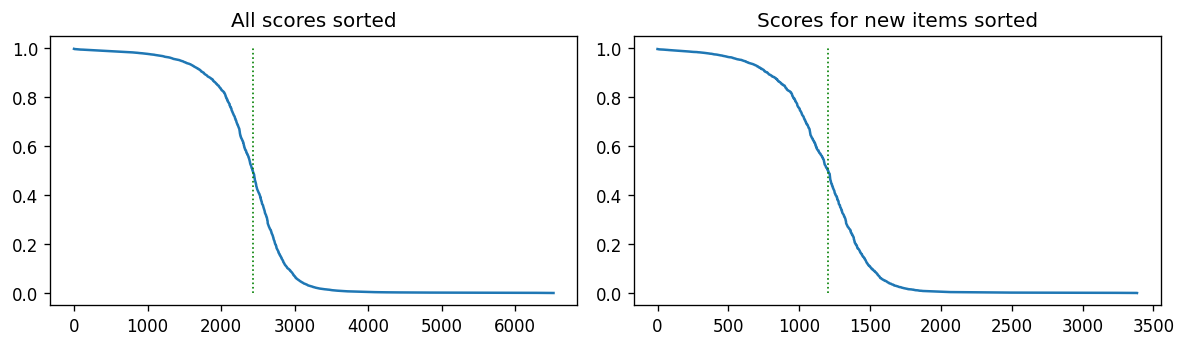

In [32]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3), dpi=120)
y = np.array(sorted(df['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax1.plot(y)
ax1.vlines(x,0,1, colors='green', ls=':', lw=1)
ax1.set_title('All scores sorted')

y = np.array(sorted(df[df['import_upd'] & ~df['import_orig']]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax2.plot(y)
ax2.vlines(x,0,1, colors='green', ls=':', lw=1)
ax2.set_title('Scores for new items sorted')
fig.tight_layout()

In [81]:
# Set all as unassigned
df['assigned'] = False

In [82]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True
LIMIT = 20

users = [
    ('josefine.hintz', JOSEFINE),
    ('nikola.milojevic', NIKOLA)
]

# sorted newly imported by relevance (highest inclusion first)
srtd = df[~df['import_orig']].sort_values('pred_incl|0')

with db_engine.session() as session:
    for name, key, mask in masks:
        title = f'20240715_prioritised_{key}_JH_NM'
        desc = f'Top {LIMIT} documents predicted, filtered for the "{name}" query (possibly excluding when higher-ranked ones if seen by other queries)'

        scope_id = str(uuid.uuid4())
        print(f'Creating scope with ID {scope_id}')
        if not DRY_RUN:
            scope = AssignmentScope(
                assignment_scope_id=scope_id,
                annotation_scheme_id=SCHEME_ID,
                name=title,
                description=desc
            )
            session.add(scope)
            session.flush()

        scope_mask = srtd.index.isin(df[mask & ~df['import_orig'] & ~df['assigned']].index)

        cnt = 0
        for di, (ri, row) in enumerate(srtd[scope_mask].head(LIMIT).iterrows()):
            item_id = row['item_id']
            df.loc[ri, 'assigned'] = True

            print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')
            for username, user_id in users:
                assi_id = uuid.uuid4()
                
                if not DRY_RUN:
                    assi = Assignment(assignment_id=assi_id,
                                      assignment_scope_id=scope_id,
                                      user_id=user_id,
                                      item_id=item_id,
                                      annotation_scheme_id=SCHEME_ID,
                                      status=AssignmentStatus.OPEN,
                                      order=di)
                    session.add(assi)
                    session.flush()
                cnt += 1
                print(f'  -> {username} via {assi_id} for scope {scope_id}')
        print(f'Created {cnt} assignments!')


Creating scope with ID 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
#1/20 | Creating assignments for eec97258-bf76-4a68-a6db-0217074c3923
  -> josefine.hintz via 900f95d5-9eb2-4c9c-8661-ecf0ce6f807b for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
  -> nikola.milojevic via 91acee73-b0c8-4a8c-b101-5ac6658b2c89 for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
#2/20 | Creating assignments for e1136b75-05f1-4f1a-8ba7-a40d3542d023
  -> josefine.hintz via 72117bc8-5146-4477-838e-e63cb0ad777b for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
  -> nikola.milojevic via 4b2f2a7c-958f-4090-a23b-a7774562b8c4 for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
#3/20 | Creating assignments for 153d6d1e-aa61-4ac3-9669-1e8388cc1898
  -> josefine.hintz via 79f55ab4-f97a-4d86-b155-cff5507c6f47 for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
  -> nikola.milojevic via 3f8b3ba7-788f-4260-9400-8d542d58cbc4 for scope 0d57d963-fab3-48ac-bfb0-b4cfb59cedff
#4/20 | Creating assignments for 300b28cf-c6be-4b5e-99c6-4f6437b2a0ce
  -> j

In [83]:
df['assigned'].sum()

100

In [97]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True
LIMIT = 20

users = [
    ('josefine.hintz', JOSEFINE),
    ('nikola.milojevic', NIKOLA),
]

# sorted newly imported by relevance (highest inclusion first)
srtd = df[~df['import_orig']].sort_values('pred_incl|0')

with db_engine.session() as session:
    for name, key, mask in masks:
        title = f'20240715_prioritised_{key}_JH_NM_FC'
        desc = f'Top {LIMIT} documents predicted, filtered for the "{name}" query (possibly excluding when higher-ranked ones if seen by other queries)'

        scope_id = str(uuid.uuid4())
        print(f'Creating scope with ID {scope_id}')
        if not DRY_RUN:
            scope = AssignmentScope(
                assignment_scope_id=scope_id,
                annotation_scheme_id=SCHEME_ID,
                name=title,
                description=desc
            )
            session.add(scope)
            session.flush()

        scope_mask = srtd.index.isin(df[mask & ~df['import_orig'] & ~df['assigned']].index)

        cnt = 0
        for di, (ri, row) in enumerate(srtd[scope_mask].head(LIMIT).iterrows()):
            item_id = row['item_id']
            if not DRY_RUN:
                df.loc[ri, 'assigned'] = True
            print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')
            
            assi_id = uuid.uuid4()
            if not DRY_RUN:
                assi = Assignment(assignment_id=assi_id,
                                  assignment_scope_id=scope_id,
                                  user_id=FELIX,
                                  item_id=item_id,
                                  annotation_scheme_id=SCHEME_ID,
                                  status=AssignmentStatus.OPEN,
                                  order=di)
                session.add(assi)
                session.flush()
            cnt += 1
            print(f'  -> Felix via {assi_id} for scope {scope_id}')

            
            assi_id = uuid.uuid4()
            username, user_id = users[di % 2]

            if not DRY_RUN:
                assi = Assignment(assignment_id=assi_id,
                                  assignment_scope_id=scope_id,
                                  user_id=user_id,
                                  item_id=item_id,
                                  annotation_scheme_id=SCHEME_ID,
                                  status=AssignmentStatus.OPEN,
                                  order=di)
                session.add(assi)
                session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')

        
        print(f'Created {cnt} assignments!')


Creating scope with ID 27ed2842-0e23-4bae-88ae-f8b170f80ecc
#1/20 | Creating assignments for 05a1728b-7c5d-45ac-b4ba-feebff58ed6e
  -> Felix via 74dd3737-2ef0-4290-abce-127bfab16693 for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
  -> josefine.hintz via b5ce7410-ce06-46eb-913a-64d5b8a9cce8 for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
#2/20 | Creating assignments for dc7dd1f1-6760-4238-a42f-979abf7cea36
  -> Felix via 9f499712-32fb-41bd-87ef-ee5d92ec7c81 for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
  -> nikola.milojevic via 021cece0-5890-4bf8-afe5-bc8f30be9a47 for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
#3/20 | Creating assignments for 0d62d43f-bd04-442e-885e-40291b65a3db
  -> Felix via 53f4a15a-3d1b-42d5-8655-0a7e22adde29 for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
  -> josefine.hintz via 0d8fa565-6580-44f0-a911-8aa133b7550d for scope 27ed2842-0e23-4bae-88ae-f8b170f80ecc
#4/20 | Creating assignments for 0790798c-f90e-4732-8ff7-d974d5f1becf
  -> Felix via 70472c5e-ce1f-4b40-b65

In [95]:
#df[df['assigned']].sort_values('pred_incl|1').head(100)['assigned'] = None

In [90]:
df['assigned'].sum()

200

In [88]:
df.to_feather(f'data/screening_round_01_post.arrow')